In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, log_loss, 
    confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay, roc_auc_score
)

sns.set_style("whitegrid")

Load Dataset

In [2]:
DATA_PATH = "csv/pneumonia_dataset.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,PatientID,Gender,Age,Cough,Fever,Shortness_of_breath,Chest_pain,Fatigue,Confusion,Oxygen_saturation,Crackles,Xray,WBC_count,Sputum_color,Temperature,Diagnosis
0,PNEU4091,M,3,Bloody,High,Mild,Mild,NaN,No,92,Yes,-,-,-,39.7,Yes
1,PNEU6231,M,3,Dry,NaN,NaN,NaN,Mild,-,-,Yes,-,-,Clear,37.0,No
2,PNEU6486,M,3,Dry,NaN,NaN,NaN,Mild,No,99,No,-,-,-,38.0,No
3,PNEU7601,F,3,NaN,Low,Severe,NaN,Moderate,No,99,Yes,-,-,Clear,40.9,Yes
4,PNEU8471,F,3,NaN,High,Moderate,Severe,Mild,-,91,No,-,-,Green,38.1,Yes


EDA (Class Distribution + Correlation)

Shape: (710, 16)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            710 non-null    object 
 1   Gender               710 non-null    object 
 2   Age                  710 non-null    int64  
 3   Cough                398 non-null    object 
 4   Fever                400 non-null    object 
 5   Shortness_of_breath  393 non-null    object 
 6   Chest_pain           367 non-null    object 
 7   Fatigue              605 non-null    object 
 8   Confusion            710 non-null    object 
 9   Oxygen_saturation    710 non-null    object 
 10  Crackles             710 non-null    object 
 11  Xray                 710 non-null    object 
 12  WBC_count            710 non-null    object 
 13  Sputum_color         710 non-null    object 
 14  Temperature          710 non-null    float64
 15  Diagnosis       

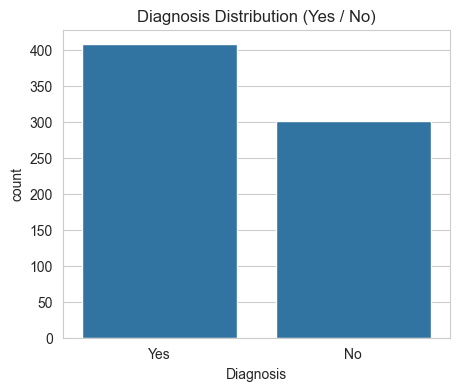

In [3]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

# Target distribution
print("\nDiagnosis value counts:")
print(df['Diagnosis'].value_counts())

plt.figure(figsize=(5,4))
sns.countplot(x='Diagnosis', data=df)
plt.title("Diagnosis Distribution (Yes / No)")
plt.show()

Numeric cols: ['Age', 'Oxygen_saturation', 'WBC_count', 'Temperature']
Categorical cols: ['Gender', 'Cough', 'Fever', 'Shortness_of_breath', 'Chest_pain', 'Fatigue', 'Confusion', 'Crackles', 'Xray', 'Sputum_color']


,Age,Oxygen_saturation,WBC_count,Temperature
count,710.000000,650.000000,10.000000,710.000000
mean,45.063380,92.644615,9394.100000,38.166479
std,25.573042,4.251875,1811.243799,1.837634
min,3.000000,85.000000,5322.000000,35.000000
25%,22.000000,89.000000,9576.000000,37.000000
50%,45.000000,93.000000,9801.500000,38.000000
75%,69.000000,96.000000,10160.750000,39.675000
max,90.000000,100.000000,11513.000000,43.000000


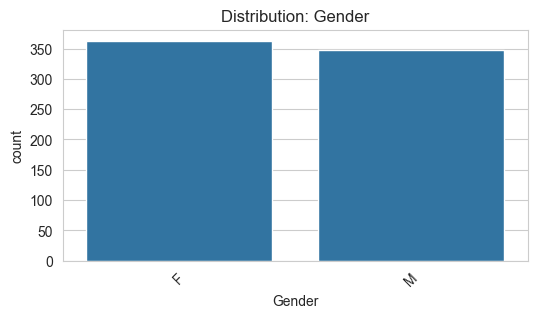

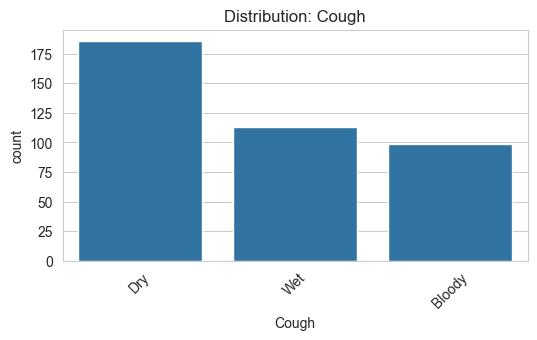

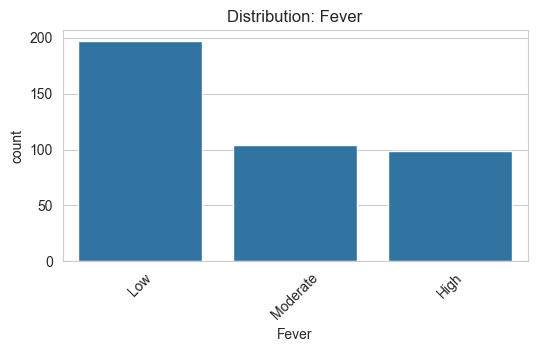

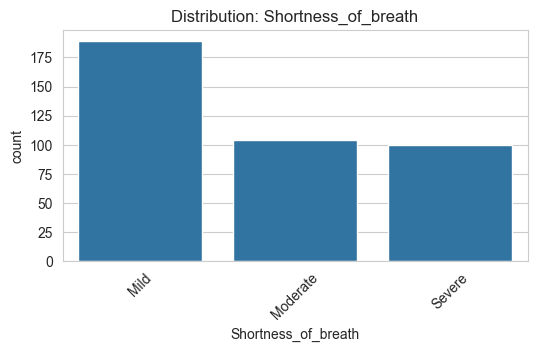

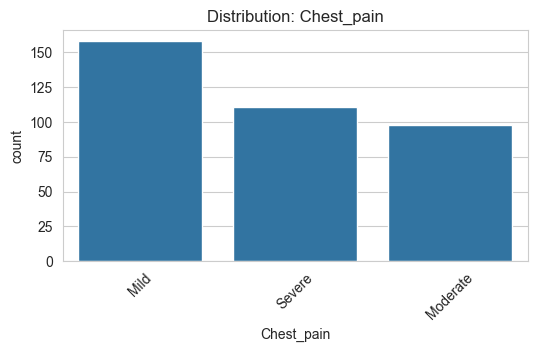

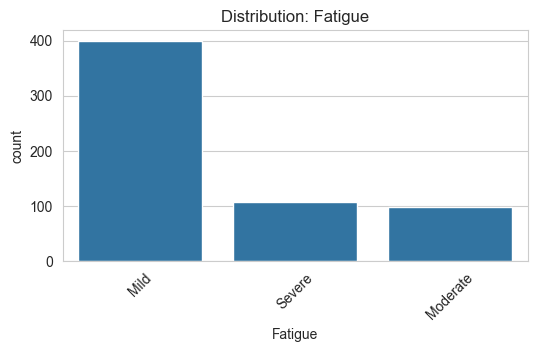

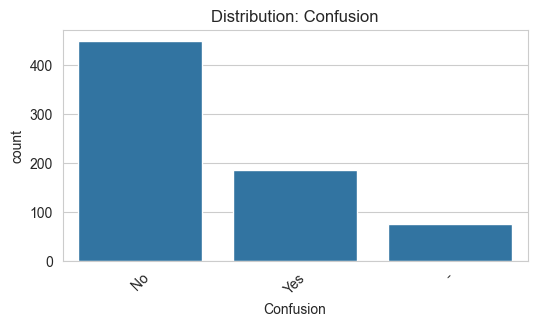

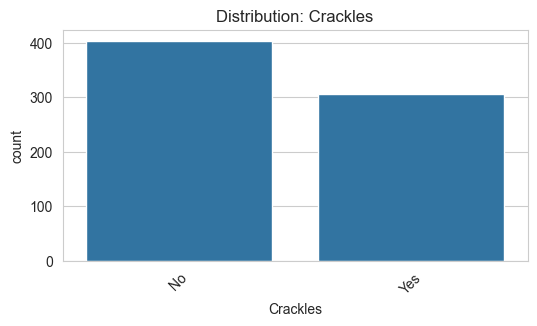

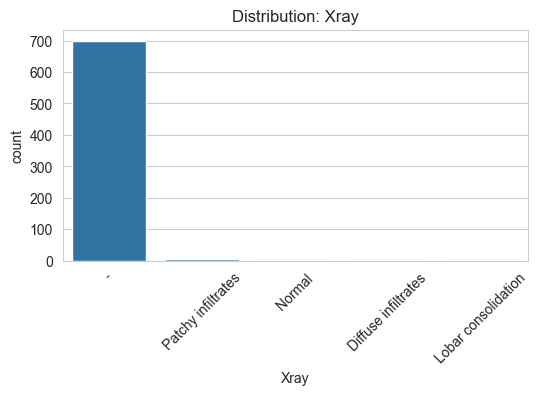

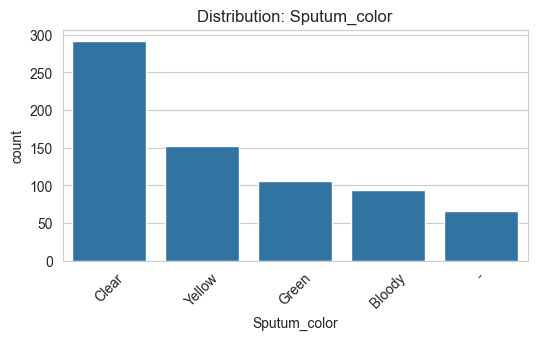

In [4]:
# Identify numeric & categorical cols manually or infer
numeric_cols = ['Age', 'Oxygen_saturation', 'WBC_count', 'Temperature']
cat_cols = [c for c in df.columns if c not in numeric_cols + ['PatientID','Diagnosis']]
print("Numeric cols:", numeric_cols)
print("Categorical cols:", cat_cols)

# Describe numeric (coerce non-numeric to NaN first)
df[numeric_cols] = df[numeric_cols].replace(['-',''], np.nan)
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

display(df[numeric_cols].describe())

# show some category distributions
for c in cat_cols:
    if c in df.columns:
        plt.figure(figsize=(6,3))
        sns.countplot(x=c, data=df, order=df[c].value_counts().index)
        plt.title(f"Distribution: {c}")
        plt.xticks(rotation=45)
        plt.show()


Correlation matrix (numerik)

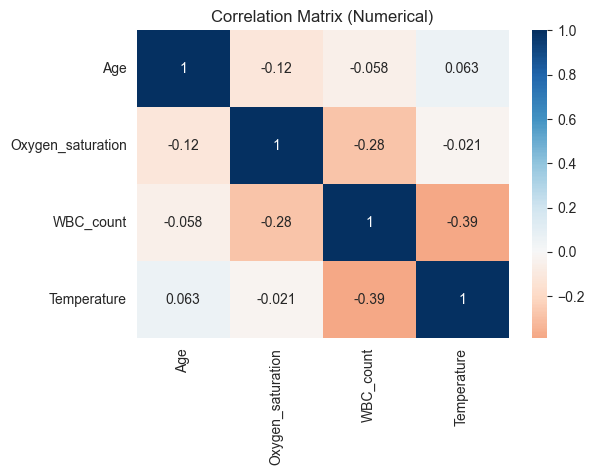

In [5]:
# Correlation heatmap (numerical features)
plt.figure(figsize=(6,4))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='RdBu', center=0)
plt.title("Correlation Matrix (Numerical)")
plt.show()


Relationship numeric vs target

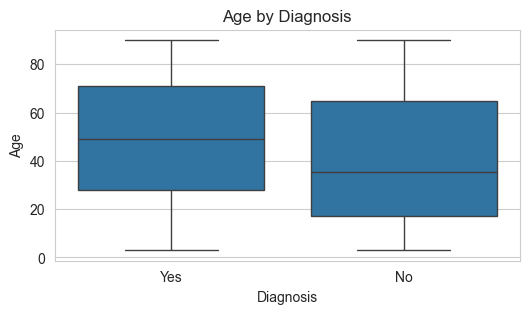

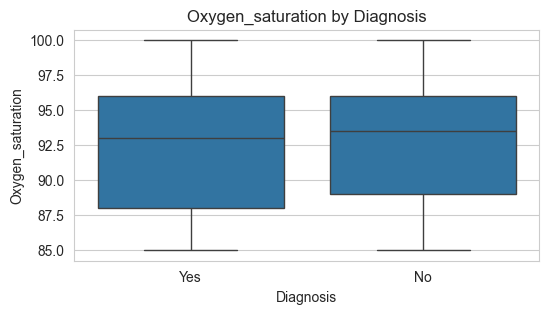

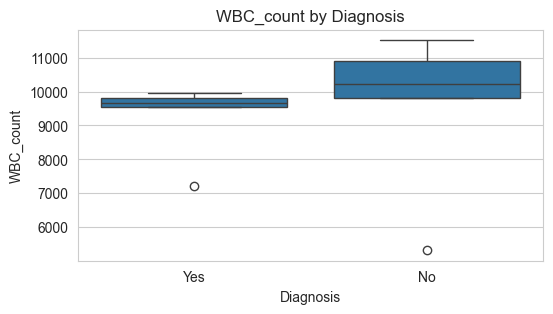

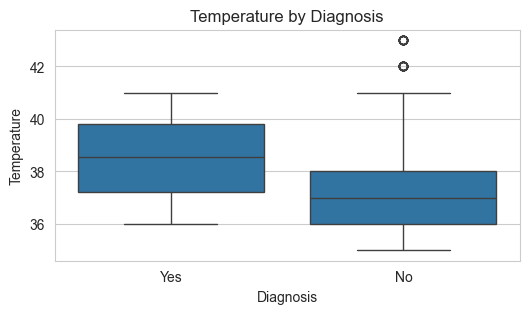

In [6]:
# Boxplots numeric vs Diagnosis

for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='Diagnosis', y=col, data=df)
    plt.title(f"{col} by Diagnosis")
    plt.show()

Target Encoding

In [7]:
df['Diagnosis_bin'] = df['Diagnosis'].map({'Yes':1, 'No':0})

print(df[['Diagnosis', 'Diagnosis_bin']].head())

  Diagnosis  Diagnosis_bin
0       Yes              1
1        No              0
2        No              0
3       Yes              1
4       Yes              1


Defenisi Fitur Numerik dan Kategorikal

In [8]:
# Clip Temperature outliers (berdasarkan EDA)
df['Temperature'] = df['Temperature'].clip(lower=36, upper=41)

numeric_cols = ['Age', 'Oxygen_saturation', 'Temperature']

cat_cols = ['Gender','Cough','Fever','Shortness_of_breath',
            'Chest_pain','Fatigue','Confusion','Crackles',
            'Xray','Sputum_color','Oxygen_missing']

print("Numeric:", numeric_cols)
print("Categorical:", cat_cols)


Numeric: ['Age', 'Oxygen_saturation', 'Temperature']
Categorical: ['Gender', 'Cough', 'Fever', 'Shortness_of_breath', 'Chest_pain', 'Fatigue', 'Confusion', 'Crackles', 'Xray', 'Sputum_color', 'Oxygen_missing']


PIPELINE PREPROCESSING (IMPUTASI + SCALING + ONE HOT)

In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
])

Build Dataset X and Y

In [10]:
df['Oxygen_missing'] = df['Oxygen_saturation'].isna().astype(int)

df[['Oxygen_saturation','Oxygen_missing']].head()

X = df[numeric_cols + cat_cols]
y = df['Diagnosis_bin']

Split Train and Test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)

Train: (568, 14)
Test : (142, 14)


Transform Data (Final Input to Models)

In [12]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

print("Final feature count:", X_train_prep.shape[1])

Final feature count: 36


Train SVM (GridSearch)

In [13]:
svm_pipe = Pipeline(steps=[
    ('clf', SVC(probability=True))
])

svm_params = {
    'clf__kernel': ['linear','rbf'],
    'clf__C': [0.1, 1, 10]
}

svm_grid = GridSearchCV(svm_pipe, svm_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
svm_grid.fit(X_train_prep, y_train)

print("Best SVM params:", svm_grid.best_params_)
svm_best = svm_grid.best_estimator_
y_pred_svm = svm_best.predict(X_test_prep)

#untuk log loss
y_proba_svm = svm_best.predict_proba(X_test_prep)
svm_logloss = log_loss(y_test, y_proba_svm)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVM params: {'clf__C': 1, 'clf__kernel': 'linear'}


Train KNN (Search Best K)

In [14]:
best_acc = 0
best_k = 1
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_prep, y_train)
    acc = knn.score(X_test_prep, y_test)
    if acc > best_acc:
        best_acc = acc
        best_k = k

print("Best K:", best_k, "with accuracy", best_acc)
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_prep, y_train)
y_pred_knn = knn_best.predict(X_test_prep)

# untuk log loss
knn_best_proba = knn_best.predict_proba(X_test_prep)

Best K: 1 with accuracy 0.8873239436619719


Train Decision Tree (GridSearch for Pruning)

In [15]:
dt = DecisionTreeClassifier(random_state=42)
dt_params = {
    'max_depth': [3,5,10,None],
    'min_samples_split': [2,5,10],
    'criterion': ['gini','entropy']
}
dt_grid = GridSearchCV(dt, dt_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
dt_grid.fit(X_train_prep, y_train)
print("Best DT params:", dt_grid.best_params_)
dt_best = dt_grid.best_estimator_
y_pred_dt = dt_best.predict(X_test_prep)

# untuk log loss
dt_best_proba = dt_best.predict_proba(X_test_prep)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best DT params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}


Train Logistic Regression

In [16]:
# Pipeline Logistic Regression
logreg_pipe = Pipeline(steps=[
    ('clf', LogisticRegression(max_iter=1000))
])

# Hyperparameter tuning
logreg_params = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['liblinear', 'lbfgs']
}

logreg_grid = GridSearchCV(
    logreg_pipe,
    logreg_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

logreg_grid.fit(X_train_prep, y_train)

print("Best Logistic Regression params:", logreg_grid.best_params_)

logreg_best = logreg_grid.best_estimator_

# Prediksi
y_pred_logreg = logreg_best.predict(X_test_prep)
y_proba_logreg = logreg_best.predict_proba(X_test_prep)

# Log Loss
logreg_logloss = log_loss(y_test, y_proba_logreg)
print("Logistic Regression Log Loss:", logreg_logloss)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Logistic Regression params: {'clf__C': 10, 'clf__solver': 'lbfgs'}
Logistic Regression Log Loss: 0.03666322360668412


Overfitting and Underfitting Analysis

In [17]:
models = {
    'SVM': svm_best,
    'KNN': knn_best,
    'DecisionTree': dt_best,
    'LogisticRegression': logreg_best
}

results = []

print("=== TRAIN vs TEST PERFORMANCE (with Log Loss) ===\n")

for name, model in models.items():
    # Prediksi
    y_train_pred = model.predict(X_train_prep)
    y_test_pred  = model.predict(X_test_prep)

    # Akurasi
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)

    # Log Loss
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train_prep)
        y_test_proba  = model.predict_proba(X_test_prep)

        train_ll = log_loss(y_train, y_train_proba)
        test_ll  = log_loss(y_test, y_test_proba)
    else:
        train_ll = None
        test_ll  = None

    results.append([name, train_acc, test_acc, train_ll, test_ll])

    print(f"{name}")
    print(f"Train Accuracy : {train_acc:.4f}")
    print(f"Test  Accuracy : {test_acc:.4f}")
    print(f"Train Log Loss : {train_ll}")
    print(f"Test  Log Loss : {test_ll}")
    print("------")

fit_df = pd.DataFrame(
    results,
    columns=['Model','Train Accuracy','Test Accuracy','Train LogLoss','Test LogLoss']
)

display(fit_df)


=== TRAIN vs TEST PERFORMANCE (with Log Loss) ===

SVM
Train Accuracy : 0.9947
Test  Accuracy : 0.9930
Train Log Loss : 0.03502582099320084
Test  Log Loss : 0.042448557289345386
------
KNN
Train Accuracy : 1.0000
Test  Accuracy : 0.8873
Train Log Loss : 2.220446049250313e-16
Test  Log Loss : 4.061256719900524
------
DecisionTree
Train Accuracy : 0.9947
Test  Accuracy : 0.9930
Train Log Loss : 0.011605059387339403
Test  Log Loss : 0.2585428453736606
------
LogisticRegression
Train Accuracy : 0.9947
Test  Accuracy : 0.9930
Train Log Loss : 0.029504353911738678
Test  Log Loss : 0.03666322360668412
------


,Model,Train Accuracy,Test Accuracy,Train LogLoss,Test LogLoss
0,SVM,0.994718,0.992958,3.502582e-02,0.042449
1,KNN,1.000000,0.887324,2.220446e-16,4.061257
2,DecisionTree,0.994718,0.992958,1.160506e-02,0.258543
3,LogisticRegression,0.994718,0.992958,2.950435e-02,0.036663


Grafik Perbandingan Train vs Test Accuracy

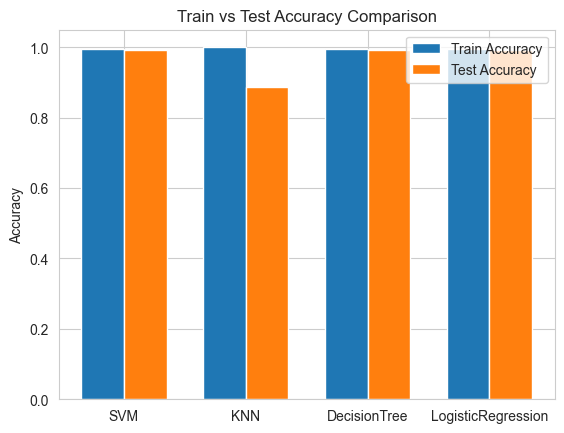

In [18]:
models = ['SVM', 'KNN', 'DecisionTree', 'LogisticRegression']
model_objs = [svm_best, knn_best, dt_best, logreg_best]

train_acc = []
test_acc = []

for model in model_objs:
    y_train_pred = model.predict(X_train_prep)
    y_test_pred  = model.predict(X_test_prep)

    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

x = np.arange(len(models))
width = 0.35

plt.figure()
plt.bar(x - width/2, train_acc, width, label='Train Accuracy')
plt.bar(x + width/2, test_acc,  width, label='Test Accuracy')

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Comparison")
plt.legend()
plt.show()

Grafik perbandingan Train vs Test Log Loss

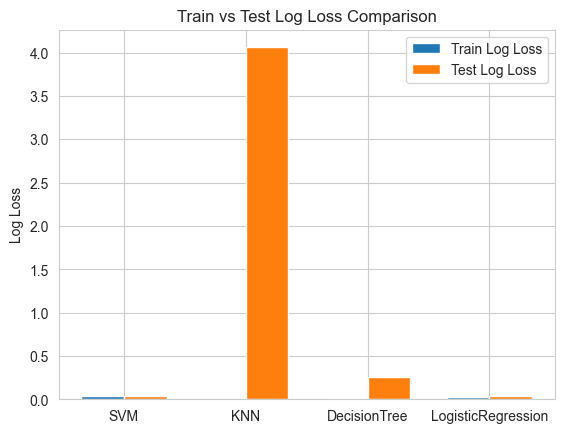

In [19]:
train_logloss = []
test_logloss = []

for model in model_objs:
    y_train_proba = model.predict_proba(X_train_prep)
    y_test_proba  = model.predict_proba(X_test_prep)

    train_logloss.append(log_loss(y_train, y_train_proba))
    test_logloss.append(log_loss(y_test, y_test_proba))

plt.figure()
plt.bar(x - width/2, train_logloss, width, label='Train Log Loss')
plt.bar(x + width/2, test_logloss,  width, label='Test Log Loss')

plt.xticks(x, models)
plt.ylabel("Log Loss")
plt.title("Train vs Test Log Loss Comparison")
plt.legend()
plt.show()

Terlihat sekali KNN sangat overfitting, jadi mari kita fix

In [20]:
#============= SVM =================
svm_pipe = Pipeline(steps=[
    ('clf', SVC(probability=True))
])

svm_params = {
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.01, 0.1, 1],          # C kecil = lebih general
    'clf__gamma': ['scale', 0.1, 0.01]
}

svm_grid = GridSearchCV(
    svm_pipe,
    svm_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train_prep, y_train)

svm_best = svm_grid.best_estimator_
y_pred_svm = svm_best.predict(X_test_prep)

print("Best SVM Params:", svm_grid.best_params_)


#============= KNN =================
knn_pipe = Pipeline(steps=[
    ('clf', KNeighborsClassifier())
])

knn_params = {
    'clf__n_neighbors': [5, 7, 9, 11, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(
    knn_pipe,
    knn_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_train_prep, y_train)

print("Best KNN params:", knn_grid.best_params_)
knn_best = knn_grid.best_estimator_

# Untuk log loss
y_proba_knn = knn_best.predict_proba(X_test_prep)
knn_logloss = log_loss(y_test, y_proba_knn)


#============= Decision Tree =================
dt_pipe = Pipeline(steps=[
    ('clf', DecisionTreeClassifier(random_state=42))
])

dt_params = {
    'clf__max_depth': [3, 5, 7, 10],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 5, 10],
    'clf__criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(
    dt_pipe,
    dt_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_train_prep, y_train)

print("Best Decision Tree params:", dt_grid.best_params_)
dt_best = dt_grid.best_estimator_

# Untuk log loss
y_proba_dt = dt_best.predict_proba(X_test_prep)
dt_logloss = log_loss(y_test, y_proba_dt)


#============= Logistic Regression =================
logreg_pipe = Pipeline(steps=[
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42
    ))
])

logreg_params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1],   # C kecil = regularisasi kuat
    'clf__solver': ['liblinear']  # support l1 & l2
}

logreg_grid = GridSearchCV(
    logreg_pipe,
    logreg_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

logreg_grid.fit(X_train_prep, y_train)

print("Best Logistic Regression params:", logreg_grid.best_params_)

logreg_best = logreg_grid.best_estimator_

# Prediksi
y_pred_logreg = logreg_best.predict(X_test_prep)

# Untuk log loss
y_proba_logreg = logreg_best.predict_proba(X_test_prep)
logreg_logloss = log_loss(y_test, y_proba_logreg)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best SVM Params: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best KNN params: {'clf__metric': 'manhattan', 'clf__n_neighbors': 5, 'clf__weights': 'distance'}
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Decision Tree params: {'clf__criterion': 'gini', 'clf__max_depth': 7, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Logistic Regression params: {'clf__C': 1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}


Testing Again

In [21]:
models = {
    'SVM': svm_best,
    'KNN': knn_best,
    'DecisionTree': dt_best,
    'LogisticRegression': logreg_best
}

results = []

print("=== TRAIN vs TEST PERFORMANCE (with Log Loss) ===\n")

for name, model in models.items():
    y_train_pred = model.predict(X_train_prep)
    y_test_pred  = model.predict(X_test_prep)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)

    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train_prep)
        y_test_proba  = model.predict_proba(X_test_prep)

        train_ll = log_loss(y_train, y_train_proba)
        test_ll  = log_loss(y_test, y_test_proba)
    else:
        train_ll = None
        test_ll  = None

    results.append([name, train_acc, test_acc, train_ll, test_ll])

    print(f"{name}")
    print(f"Train Accuracy : {train_acc:.4f}")
    print(f"Test  Accuracy : {test_acc:.4f}")
    print(f"Train Log Loss : {train_ll}")
    print(f"Test  Log Loss : {test_ll}")
    print("------")

fit_df = pd.DataFrame(
    results,
    columns=['Model','Train Accuracy','Test Accuracy','Train LogLoss','Test LogLoss']
)

display(fit_df)


=== TRAIN vs TEST PERFORMANCE (with Log Loss) ===

SVM
Train Accuracy : 0.9947
Test  Accuracy : 0.9930
Train Log Loss : 0.03531482686261389
Test  Log Loss : 0.04319412860281697
------
KNN
Train Accuracy : 1.0000
Test  Accuracy : 0.8310
Train Log Loss : 2.220446049250313e-16
Test  Log Loss : 0.7494726829670625
------
DecisionTree
Train Accuracy : 0.9947
Test  Accuracy : 0.9930
Train Log Loss : 0.028502632020309424
Test  Log Loss : 0.03621038721943009
------
LogisticRegression
Train Accuracy : 0.9930
Test  Accuracy : 0.9859
Train Log Loss : 0.05661976055745115
Test  Log Loss : 0.07402548911819168
------


,Model,Train Accuracy,Test Accuracy,Train LogLoss,Test LogLoss
0,SVM,0.994718,0.992958,3.531483e-02,0.043194
1,KNN,1.000000,0.830986,2.220446e-16,0.749473
2,DecisionTree,0.994718,0.992958,2.850263e-02,0.036210
3,LogisticRegression,0.992958,0.985915,5.661976e-02,0.074025


Train vs Test Again Bar Plot

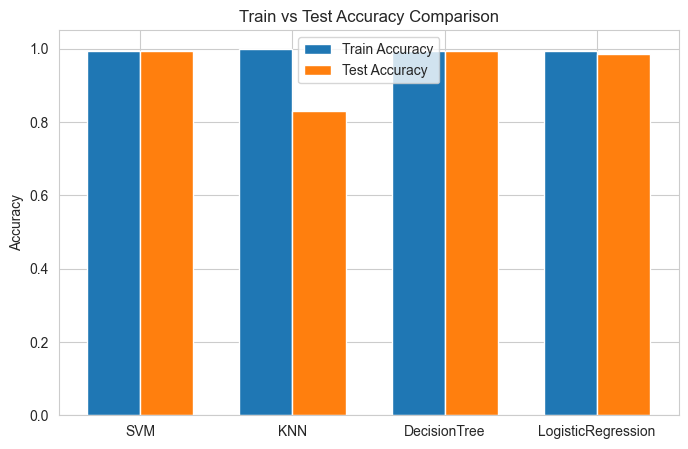

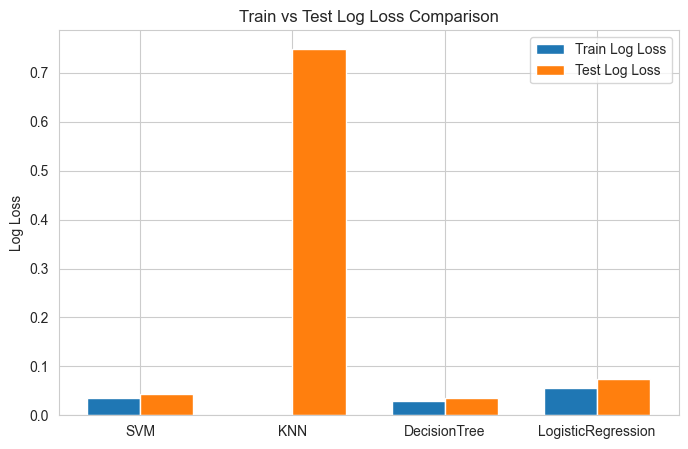

In [22]:
# Bar plot: Accuracy
plt.figure(figsize=(8,5))
x = np.arange(len(fit_df['Model']))
width = 0.35

plt.bar(x - width/2, fit_df['Train Accuracy'], width, label='Train Accuracy')
plt.bar(x + width/2, fit_df['Test Accuracy'], width, label='Test Accuracy')

plt.xticks(x, fit_df['Model'])
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Comparison")
plt.legend()
plt.show()


# Bar plot: Log Loss
plt.figure(figsize=(8,5))
plt.bar(x - width/2, fit_df['Train LogLoss'], width, label='Train Log Loss')
plt.bar(x + width/2, fit_df['Test LogLoss'], width, label='Test Log Loss')

plt.xticks(x, fit_df['Model'])
plt.ylabel("Log Loss")
plt.title("Train vs Test Log Loss Comparison")
plt.legend()
plt.show()


PRECISION, RECALL, F1-SCORE, & AUC Comparison

In [23]:
metrics = []

models = {
    'SVM': svm_best,
    'DecisionTree': dt_best,
    'LogisticRegression': logreg_best
}

for name, model in models.items():
    y_pred = model.predict(X_test_prep)
    y_proba = model.predict_proba(X_test_prep)[:,1]

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, y_proba)

    metrics.append([name, prec, rec, f1, auc])

metrics_df = pd.DataFrame(
    metrics,
    columns=['Model','Precision','Recall','F1-score','AUC']
)

display(metrics_df)

,Model,Precision,Recall,F1-score,AUC
0,SVM,1.0,0.987805,0.993865,0.993089
1,DecisionTree,1.0,0.987805,0.993865,0.993902
2,LogisticRegression,1.0,0.975610,0.987654,0.996341


Confusion Matrix

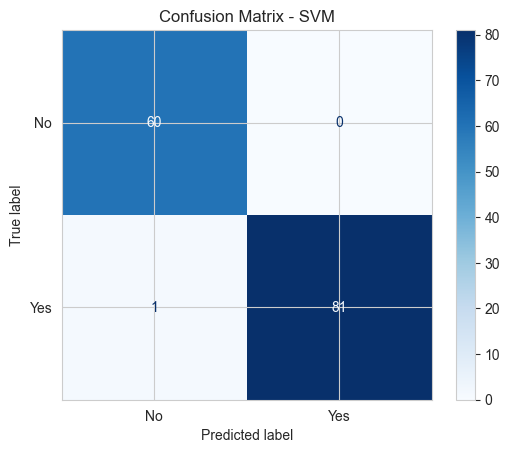

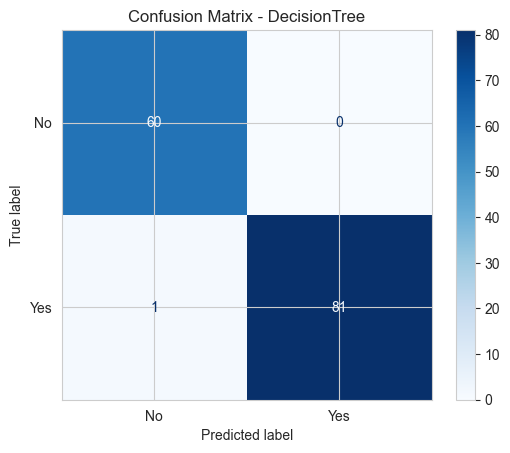

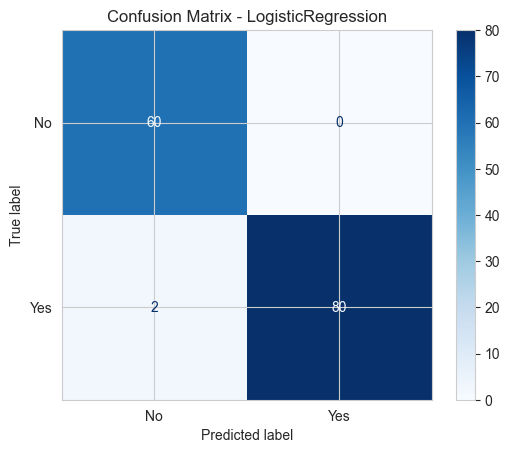

In [24]:
for name, model in models.items():
    y_pred = model.predict(X_test_prep)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['No', 'Yes']
    )
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

ROC CURVE

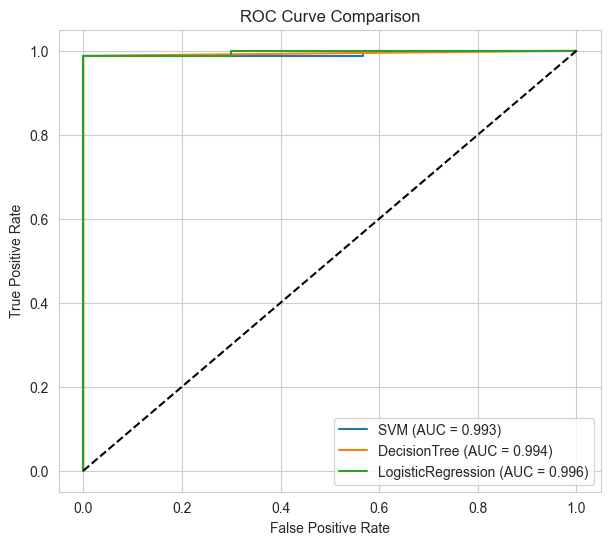

In [25]:
plt.figure(figsize=(7,6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test_prep)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()